# Paediatric X-ray image Classification


---

# Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score

from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from time import process_time
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# creating an image generator for train, validation and test sets
train_direct = 'data/train'
val_direct = 'data/val'
test_direct = 'data/test'
batch_size = 128
height_width = 128 # using lower resolution values for decreased computational strain and faster training speeds
datagen = ImageDataGenerator(rescale=1/255)

# training image generator
train_data = datagen.flow_from_directory(directory=train_direct,
                                   batch_size=batch_size,
                                   target_size=(height_width, height_width),
                                   class_mode='binary',
                                   seed=42)

# validation image generator
val_data = datagen.flow_from_directory(directory=val_direct,
                                   batch_size=batch_size,
                                   target_size=(height_width, height_width),
                                   class_mode='binary',
                                   seed=42)

# test image generator
test_data = datagen.flow_from_directory(directory=test_direct,
                                   batch_size=batch_size,
                                   target_size=(height_width, height_width),
                                   class_mode='binary',
                                   seed=42)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# producing the next batch of 128 images and their labels for training data
images, labels = next(train_data)

In [4]:
images.shape

(128, 128, 128, 3)

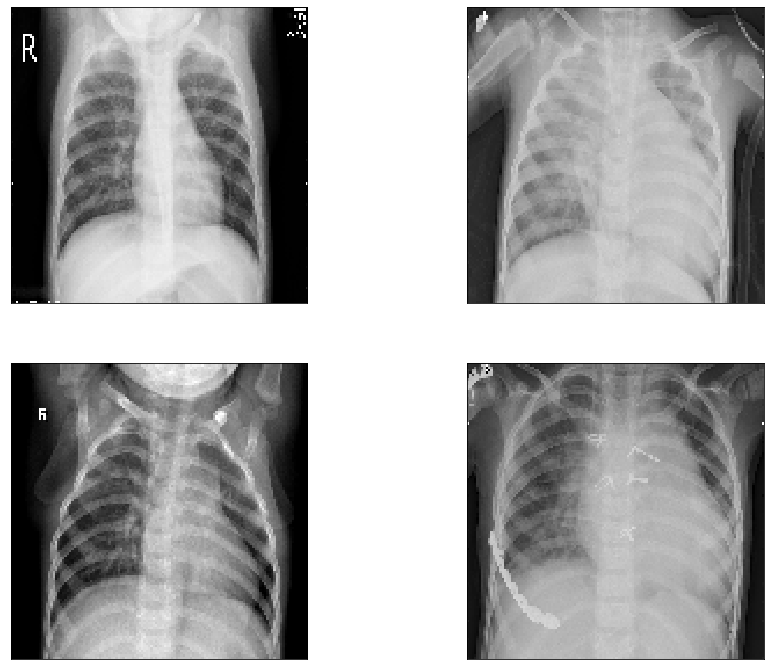

In [5]:
# quick inspection of the images

# small sample of 4 images
sample = images[::32]

# all 4 images shown with no axis ticks
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,12))
ax1.imshow(sample[0])
ax1.set_xticks([])
ax1.set_yticks([])
# ax1.set_title(sample_labl[0])

ax2.imshow(sample[1])
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(sample[2])
ax3.set_xticks([])
ax3.set_yticks([])

ax4.imshow(sample[3])
ax4.set_xticks([])
ax4.set_yticks([]);

In [6]:
# quick inspection of the labels
labels

array([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0.], dtype=float32)

### Thoughts on initial inspection:
Some of the images include details of the clothing worn by the patients as well as labels presumably for the use of the radiologists. I beleive that these minute details will not have an adverse effect on the models predictive power as long as the details offer no indication as to what class each image belongs to, which will lead to the neural net fitting to those details as apposed to generalising the trends in the xrays of the patients themselves

### Thoughts on sample sizes:
- Training set size and split between classes
- Validation set size and split between classes
- Test set size and split between classes
- What is the prevalence of the data set?

# Modelling

In [7]:
# building a very simple baseline convolutional network with maximum 16 nodes to increase computational speed 

base_cnn = models.Sequential() # simple feed-forward architecture
base_cnn.add(layers.Conv2D(8, input_shape=(height_width, height_width, 3), kernel_size=(3,3), activation='relu'))
base_cnn.add(layers.MaxPooling2D(pool_size = (2,2)))
base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(8, activation='relu'))
base_cnn.add(layers.Dense(1, activation='sigmoid')) # binary output of class prediction


base_cnn.compile(optimizer='adam', # cost function used to minimise overall model inaccuracy
                loss='binary_crossentropy', # loss function applicable to a binary classification
                metrics=['accuracy']) # a calculation of the %tage of correct predictions out of all the models predictions

base_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 254024    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 254,257
Trainable params: 254,257
Non-trainable params: 0
_________________________________________________________________


In [8]:
train_step_size = train_data.n // batch_size
val_step_size = val_data.n // batch_size
epochs = 1

start_time = process_time() # stopwatch timer started
base_cnn.fit_generator(train_data,
                       steps_per_epoch=train_step_size,
                       epochs=epochs,
                       verbose=1,
                       validation_data=val_data,
                       validation_steps=val_step_size);
stop_time = process_time() # stopwatch timer ended


total_min = np.floor((stop_time-start_time)/ 60) # number of minutes to train
remain_sec = np.round((stop_time-start_time)% 60) # number of seconds to train
print('------------------------------------------------------------------------------------------------------------------')
print(f'Time to train: {int(total_min)} mins {int(remain_sec)} secs')

Epoch 1/1
40/40 [==============================] - 82s 2s/step - loss: 0.5576 - accuracy: 0.7504 - val_loss: 0.8084 - val_accuracy: 0.5000
Time to train: 3 mins 22 secs


### Thoughts on the model:
- Training accuracy: is much higher than expected at ~75% considering the images were generated at lower resolutions and the model is almost as simple as possible with few nodes and very few layers
- Validation accuracy: very low at 50% but this may have a lot to do with the incredibly small validation set size
- Train time: as expected the time to train only took a 3 minutes even though there is no discrete graphics card being used

*Conclusion:* I have a feeling the validation set is too small to really make meaningful comparisons with the models perfomance on the training data versus its performance on the validation data. Using only 1 epoch also makes comparison a bit more difficult but the purpose of this model was to have a base line that functions and nothing more. Besides that the disparity between the training and validation accuracy seems to be a sign of overfitting
<br><br>
*Next iteration:*

# Conclusion